In [2]:
import numpy as np
import joypy
from matplotlib import pyplot as plt
from matplotlib import cm

from scipy import ndimage as ndi
from scipy.spatial import distance

from skimage import io
from skimage.color import rgb2gray
from scipy import ndimage
from skimage import filters
from skimage.morphology import disk, ball

from PIL import Image, ImageDraw, ImageFilter
import copy
import cv2


In [8]:
grain1_name='Ultra_Co6_2-040.jpg'
grain2_name='Ultra_Co11-2.jpg'
grain3_name='Ultra_Co25-1.jpg'

path='images'

grain1_pil=Image.open(path+'/'+grain1_name)
grain2_pil=Image.open(path+'/'+grain2_name)
grain3_pil=Image.open(path+'/'+grain3_name)

In [9]:
def img_show(image,N=20,cmap=plt.cm.nipy_spectral):
    
    plt.figure(figsize=(N,N))
    plt.axis('off')
    plt.imshow(image,cmap=cmap)
    plt.show()

def imdivide(image,side):
    
    width,height = image.size
    sides={'left':0,'right':1}
    shape=[(0,0,width//2,height),(width//2,0,width,height)]
    return image.crop(shape[sides[side]])

def combine(image,k=0.5,N=20): 
    left_img=imdivide(image,'left')
    right_img=imdivide(image,'right')

    l=k
    r=1-l
    gray=np.array(left_img)*l
    gray+=np.array(right_img)*r
    gray=gray.astype('uint8')
    return gray

def do_otsu(img,N=20):
    image=rgb2gray(img)
    
    global_thresh=filters.threshold_otsu(image)
    binary_global = image > global_thresh
    
    return binary_global

## Выделение пустот

denoised=mean_filter(image)

binary=otsu(denoised)

grad=gradient(binary)

bin_grad=-binary+grad

In [139]:
combined1=combine(grain1_pil,0.5,10)
combined2=combine(grain2_pil,0.5,10)
combined3=combine(grain3_pil,0.5,10)

denoised1 = filters.rank.median(combined1, disk(3))
denoised2 = filters.rank.median(combined2, disk(3))
denoised3 = filters.rank.median(combined3, disk(3))

binary1=do_otsu(denoised1).astype('uint8')
binary2=do_otsu(denoised2).astype('uint8')
binary3=do_otsu(denoised3).astype('uint8')

grad1 = filters.rank.gradient(binary1, disk(1))
grad2 = filters.rank.gradient(binary2, disk(1))
grad3 = filters.rank.gradient(binary3, disk(1))

# у зерен значение пикселя - 0, у тела пустоты - 1, у границы пустоты - 2
bin_grad1=1-binary1+grad1
bin_grad2=1-binary2+grad2
bin_grad3=1-binary3+grad3

image1=(bin_grad1>0).astype('uint8')*255
image2=(bin_grad2>0).astype('uint8')*255
image3=(bin_grad3>0).astype('uint8')*255

C:\Users\Администратор\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:27: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.


In [ ]:
#io.imsave('bin_grad.png',image)

## Маркировка углов

http://espressocode.top/python-corner-detection-with-shi-tomasi-corner-detection-method-using-opencv/

classes - каждому пикселю дается свой класс, по картинке гуляет матрица свертки

In [182]:
def mark_corners(image):
    image=copy.copy(image)
    corners = cv2.goodFeaturesToTrack(image, 1000000, 0.001, 1)

    corners = np.int0(corners)
    print('number of corners: ',len(corners))
    for i in corners:
        x, y = i.ravel()
        cv2.circle(image, (x, y), 3, 255, -1)
    x=copy.copy(corners[:,0,1])
    y=copy.copy(corners[:,0,0])
    corners[:,0,0],corners[:,0,1]=x,y
    return image,corners.astype('int64')

def mark_classes(image):
    classes = filters.rank.gradient(image, disk(1)) < 250
    classes,num = ndi.label(classes)
    print('number of classes:',num)
    return classes,num

In [183]:
grain1_marked,grain1_corners=mark_corners(image1)
grain2_marked,grain2_corners=mark_corners(image2)
grain3_marked,grain3_corners=mark_corners(image3)

grain1_classes,class1_num=mark_classes(image1)
grain2_classes,class2_num=mark_classes(image2)
grain3_classes,class3_num=mark_classes(image3)

number of corners:  1633
number of corners:  13247
number of corners:  30747
number of classes: 196
number of classes: 342
number of classes: 1244


## Дадим каждой вершине привязку к пустоте

In [56]:
def join_corners2classes(classes,classes_num,corners,max_corners_per_class):

    shape=(classes_num+1,max_corners_per_class)
    nodes=np.zeros(shape,dtype='int64')
    r=2
    for i,corner in enumerate(corners):
        x=corner[0][0]
        y=corner[0][1]
        cls=classes[x,y]
        real_cls=0
        flag=True
        x_lin=range(x-r,x+r)
        y_lin=range(y-r,y+r)
        while flag:
            for xi in x_lin:
                for yi in y_lin:
                    if classes[xi,yi]!=0 and classes[xi,yi]!=1 and classes[xi,yi]!=2:
                        real_cls=classes[xi,yi]
                        flag=False
                    elif yi==y_lin[-1] and xi==x_lin[-1]:
                        flag=False
                    else:
                        continue 

        index=nodes[real_cls,-1]
        nodes[real_cls,index]=i
        nodes[real_cls,-1]+=1
    return nodes

In [199]:
nodes1=join_corners2classes(grain1_classes,
                             class1_num,
                             grain1_corners,
                             100)

nodes2=join_corners2classes(grain2_classes,
                             class2_num,
                             grain2_corners,
                             500)

nodes3=join_corners2classes(grain3_classes,
                             class3_num,
                             grain3_corners,
                             500)

## Визуализируем графы каждой пустоты

In [ ]:
for node in nodes[2:].astype('int64'):
    indeces=[]
    for index in node:
        if index!=0:
            indeces.append(index)
    cls_corners=corners[indeces]
    for corner1 in cls_corners:
        for corner2 in cls_corners:
            x1=corner1[0][0]
            y1=corner1[0][1]
            x2=corner2[0][0]
            y2=corner2[0][1]
            draw.line((y1,x1,y2,x2), fill=(185), width=1)
                
test_image.save('edge.jpg')

## Подсчитаем количество углов у пустот

In [153]:
def show_corners_classes(nodes,classes,N=2000): 
    node_corner_numbers=np.zeros((classes.shape[0],1))
    for i,node in enumerate(nodes):
        for corner in node:
            if corner:
                node_corner_numbers[i]+=1

    std=node_corner_numbers.std(axis=0)[0]
    mean=node_corner_numbers.mean(axis=0)[0]

    print('std: ',round(std,3))
    print('mean: ',round(mean,3))
    print('number of classes: ',classes.shape[0])
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_ylabel('Количество углов у пустоты',size=20)
    ax.set_xlabel('Порядковый номер пустоты',size=20)
    plt.plot(node_corner_numbers[:N])

std:  31.914
mean:  19.13
number of classes:  1671


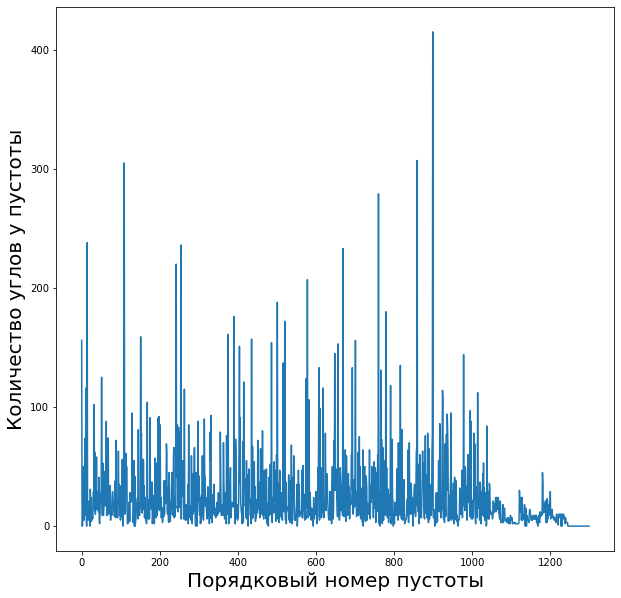

In [185]:
N=1300
show_corners_classes(nodes3,grain3_classes,N)

## Подсчитаем количество пустот, в которые входит угол

In [119]:
def show_classes_corners(nodes,corners,N=2000):   
    corner_distr=np.zeros((corners.shape[0]))
    
    for i in range(corners.shape[0]):
        for node in nodes:
            if i in node:
                corner_distr[i]+=1
                
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_ylabel('Количество вхождений в пустоту',size=20)
    ax.set_xlabel('Порядковый номер угла',size=20)
    plt.plot(corner_distr[:N])
    plt.show()

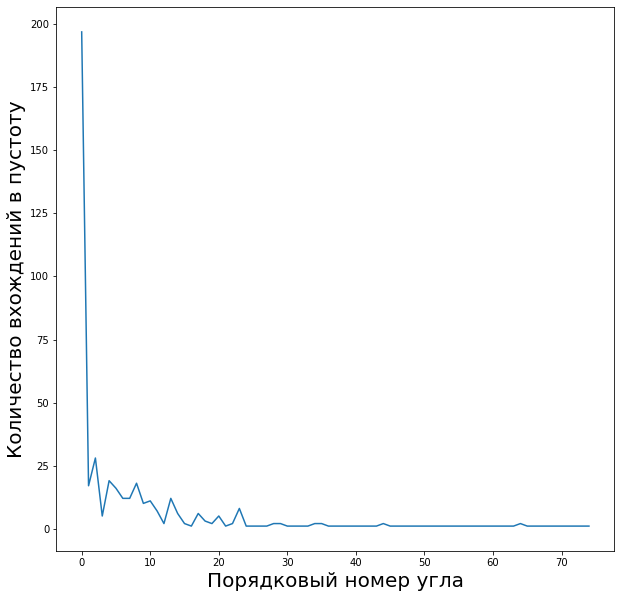

In [155]:
k=75
show_classes_corners(nodes1,grain1_corners,k)

## Соединим углы пустоты по периметру

In [253]:
def mean_pixel(image,point1,point2,r):
    val=0
    num=0
    image=rgb2gray(image)
    x1,y1=point1[0],point1[1]
    x2,y2=point2[0],point2[1]

    # идем всегда из х1 в х2, сверху вниз
    if x1>x2:
        x1,y1,x2,y2=x2,y2,x1,y1

    y_lin=[]
    x_lin=range(x1,x2)
    # проведем линию и сохраним ее координаты
    for xi in x_lin:
        y_lin.append(round(((xi-x1)/(x2-x1))*(y2-y1)+y1))
    # координатная ось повернута на -90 градусов
    # новый х=-y, новый y=x

    x_lin=np.array(x_lin,dtype='int64')
    y_lin=np.array(y_lin,dtype='int64')
    for xi,yi in zip(y_lin,x_lin):
        for x in range(xi-r,xi+r):
            for y in range(yi-r,yi+r):

                val+=image[y,x]
                num+=1
    if num==0:
        mean=0
    else:
        mean=abs(((val/num)/255)-0.5)
    
    dist=distance.euclidean(point1,point2)
        
    return round(mean*dist,3)

In [254]:
def estimate_edges(image,node,corners,position=0,radius=2):
    # вычисление расстояния и среднего значения между 
    # точкой с индексом posion и остальными точками пустоты
    v1=node[position]
    vals=np.zeros((node.shape[0],2))
    if v1!=0:
        for i,v2 in enumerate(node):

            if v2!=0 and v1!=v2  :
                vals[i,0]=v2
                point1=corners[v1]
                point2=corners[v2]
                k=mean_pixel(image,point1[0],point2[0],radius)
                vals[i,1]=k
    return vals
        

In [281]:
def sort_perimetr(image,nodes,corners,radius=5):
        new_nodes=np.zeros(nodes.shape)
        i=0
        node=nodes[i]
    # проходим по каждой пустоте
   # for i,node in enumerate(nodes):
    # node - пустота
        v1_index=0
        v1=node[v1_index] # фиксируем первый угол и затем будем считать относительно него
        new_nodes[i,v1_index]=v1
        step=1
        flag=True
        if v1!=0:
            print('old_node',node[:node[-1]])
            val_node=copy.copy(node)
            while flag:
                print('v1_index',v1_index)
                vals=estimate_edges(image, val_node,corners,position=v1_index,radius=radius)
               # print('vals',vals)
                non_zero_indeces=np.where((vals[:,0][:node[-1]]!=0) )[0]
                vals=vals[non_zero_indeces]
                min_val=vals.min(axis=0)[1]
                
                v2_index=np.where(vals[:,1]==min_val )[0][0]
                v2=val_node[v2_index]

                print('v2_index',v2_index)
                print('--------------')
                
                new_nodes[i,step]=v2
                val_node= np.delete(val_node, (v2_index), axis=0)
                
                v1=v2
                v1_index=v2_index
                
                step+=1
               
                if step==node[-1]:
                    print('new_node',new_nodes[i,:node[-1]])
                    print('===============')
                    new_nodes[i,-1]=node[-1]
                    flag=False
     #   else:
      #      continue

        return new_nodes

In [282]:
image=image2
N=212
max_dist=80
# 46
position=4
#vals=estimate_edges(image,nodes[N],corners,position=position,radius=5)

#img=draw_edges(image,position,node.astype('int64'),vals,corners,max_dist)

new_nodes=sort_perimetr(image1,nodes2,grain2_corners)

#img_show(img,cmap='gray',N=12)
#io.imsave('vals.png',img)

old_node [   33   107   215   424   511   675   677   678   679  1285  2008  2013
  2018  2020  2022  2722  2761  2786  2840  2870  2874  2934  2954  2958
  2987  3028  3029  3036  5667  5668  5673  5674  5677  5678  5680  5705
  5706  5712  5750  5756  5757  8318  8345  8350  8358  8365  8380  8383
  8389  8393  8440  8443  8458  8459  8461  8465  8467  8471  9982 10011
 10014 10018 10019 10022 10023 10024 10025 10026 10041 10043 11582 12446
 12450 12451 12452 12453 13214 13215 13216]
v1_index 0


C:\Users\Администратор\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:4: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  after removing the cwd from sys.path.


v2_index 18
--------------
v1_index 18
v2_index 0
--------------
v1_index 0
v2_index 1
--------------
v1_index 1
v2_index 0
--------------
v1_index 0
v2_index 13
--------------
v1_index 13
v2_index 51
--------------
v1_index 51
v2_index 13
--------------
v1_index 13
v2_index 43
--------------
v1_index 43
v2_index 17
--------------
v1_index 17
v2_index 46
--------------
v1_index 46
v2_index 17
--------------
v1_index 17
v2_index 17
--------------
v1_index 17
v2_index 8
--------------
v1_index 8
v2_index 52
--------------
v1_index 52
v2_index 8
--------------
v1_index 8
v2_index 8
--------------
v1_index 8
v2_index 33
--------------
v1_index 33
v2_index 33
--------------
v1_index 33
v2_index 8
--------------
v1_index 8
v2_index 21
--------------
v1_index 21
v2_index 8
--------------
v1_index 8
v2_index 31
--------------
v1_index 31
v2_index 32
--------------
v1_index 32
v2_index 31
--------------
v1_index 31
v2_index 22
--------------
v1_index 22
v2_index 34
--------------
v1_index 34
v2

In [284]:
new_nodes

array([[  33., 2840.,   33., ...,    0.,    0.,   79.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       ...,
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.]])

In [127]:
def draw_edges(image,node,corners,color=(51,51,51)):
    new_image=copy.copy(image)
    
    v1=node[position]
    point1=corners[v1][0]
    x1,y1=point1[0],point1[1]
    image=rgb2gray(image)
    
    im = Image.fromarray(np.uint8(cm.gist_earth(image)*255))
    draw = ImageDraw.Draw(im)
    rx=3
    draw.ellipse((y1-r,x1-r,y1+r,x1+r), fill=(), width=1)
    
    for val in vals:
        point2=corners[val[0].astype('int64')][0]
        x2,y2=point2[0],point2[1]
        
        draw.ellipse((y2-r,x2-r,y2+r,x2+r), fill=color, width=1)
        
        if val[0]!=v1 and val[0]!=0 and val[2]<=max_dist:
          #  draw.line((y1,x1,y2,x2), fill=color, width=1)
            draw.text(
                    (y2,x2),
                    str(val[1]),
                    fill=('#828282')
                    )
            
        else:
            continue
    img=np.array(im)
    img=rgb2gray(img)

    return  img
        